# FastText를 활용한 비속어탐지 사전 구축
---
- word embeedding은 window size(좌우단어)를 보고 embedding하므로 전체 단어를 넣어 돌렸다.
 - 트라이그램으로 하면 word embedding이 큰 의미가 없다!

 
- fasttext를 활용한 이유는 변형된 비속어도 많아 char단위로 학습하는 fasttext가 OOV를 해결하기에 좋아 사용

- 기존 word embedding모델 처럼 같은단어라도 좌우 문맥에 따라 의미를 달리하는 경우도 뽑기 위함

- 자모분리를 한 이유는 각 단어를 ngram하여 embedding하는데 한글 같은경우는 음절단위로 나누어져 의미를 제대로 못담기 때문

- 형태소 분리를 하지 않은 이유는 비속어라 형태소가 적절하게 분리되지 않는 것이 많아 어절단위로 사용

# ==== 크롤한 데이터 전부 합치기(네이버 카페, 블로그, 뉴스, 디씨인사이드, 네이트 뉴스) ====

In [1]:
import os
import pandas as pd
import numpy as np
base_path = "../bad_words_data/sentence/"
fileList = os.listdir(base_path)[1:]

# 모든 문장을 하나의 데이터프레임으로 concat
all_Sentences = pd.DataFrame()

for file in fileList:
    file_name = base_path + file
    if file.endswith("csv"):
        
        df = pd.read_csv(file_name, encoding="utf-8", header=None, names=[0])
        if file.endswith("BWstc_All.csv"):
            df[0] = df[0].astype('str')
            df[0] = df[0].apply(lambda x: x.split("-")[0] if x.endswith("갤러리") else x)
            
        all_Sentences = pd.concat([all_Sentences, df])
        
    else:
        all_Sentences = pd.concat([all_Sentences, pd.read_excel(file_name, encoding="utf-8", header=None, names=[0])])
    print(file_name, len(df), len(all_Sentences))

../bad_words_data/sentence/naver_cafe_crawl_data.csv 67528 67528
../bad_words_data/sentence/BWstc_NaverNews.csv 70718 138246
../bad_words_data/sentence/BWstc.xlsx 70718 166495
../bad_words_data/sentence/BWstc_NaverNews2.csv 29860 196355
../bad_words_data/sentence/nate_news_crawl_data.csv 2547 198902
../bad_words_data/sentence/BWstc_All.csv 325716 524618


# ==== FastText input만들기 ====

In [2]:
# 중복제거 : 524618 => 351539
all_Sentences.drop_duplicates(inplace=True)
print(len(all_Sentences))

351539


In [3]:
# 특수문자나 한자 등이 안날라 갔을 경우를 처리
import re
pattern = re.compile("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z ]") # 한글 숫자 영어 공백 말고 제거

# 각 단어에 해당 해당 정규표현식 적용
def clear_word(word):
    word = re.sub(pattern, "", word)
    return word

all_Sentences[0] = all_Sentences.astype('str')
all_Sentences[0] = all_Sentences[0].apply(lambda x: clear_word(x))

In [4]:
# index 뒤죽박죽 된 것 재정비
all_Sentences.reset_index(inplace=True)
all_Sentences.drop('index', axis=1, inplace=True)
all_Sentences = all_Sentences[1:]

In [5]:
# 각 문장을 jamo_split하여 저장
from JamoSplit import jamo_split, jamo_combine
all_Sentences[0] = all_Sentences[0].apply(lambda x: jamo_split(x))
all_Sentences[0] = all_Sentences[0].apply(lambda x: x.split(" "))

In [6]:
# 데이터 확인: 정상적으로 자모분리한 형태로 문장단위로 만들어짐
all_Sentences

,0
1,"[ㅇㅏ_ㅈㅣㄱㄷㅗ_, ㅉㅗㅊ, ㅈㅗㅊ, ㅁㅗ_ㄹㅡ_ㄴㅡㄴ, ㅅㅏ_ㄹㅏㅁㅇㅣ_, ㅇㅣ..."
2,"[ㄹㅔ_ㅈㅓㄴㄷㅡ_1ㄱㅜㄴ, ㅈㅓ_ㅇㅓ_ㅇㅓ_ㅇㅓ_ㅇㅓㅇㅁㅏ_ㅇㅏ_ㅇㅏ_ㅇㅏ_ㅇㅏㄹ..."
3,"[ㅇㅣ_ㄱㅓ_, ㅈㅗㅊㅇㅣ_, ㅇㅏ_ㄴㅣ_ㄹㅏ_, ㅉㅗㅊ, ㅇㅏ_ㄴㅣ_ㅇㅖ_ㅇㅛ_]"
4,"[ㅇㅐ_ㄴㅣ_, ㅈㅗㅊ1ㅂㅏㅂㅇㅢ_, ㅇㅐ_ㄴㅣ_ㅅㅜㄴㅇㅟ_, top10ㅇㅣㅂㄴㅣ_..."
5,"[ㄱㅚ_ㅇㅠ_ㅇㅏㅂㄹㅗㄱㄱㅏㅇ, ㄱㅡㄴㅊㅓ_ㅇㅔ_ㅅㅓ_, ㅎㅏ_ㄴㅡㄹㅇㅢ_, ㄸㅡㅅ..."
...,...
351534,"[ㅇㅏ_ㄴㅣ_, ㅅㅣ_ㅂㅏㄹ, ㄱㅕㄹㅈㅔ_, ㅈㅗㅈㄱㅏㅌㅇㅣ_, ㅎㅐ_ㄴㅘㅆㄴㅔ_, ]"
351535,"[ㅅㅡ_ㄷㅗㄱ, ㅁㅏㅇㅎㅏㅁㅇㅢ_, ㅇㅝㄴㅇㅣㄴㅇㅡㄴ, ㅎㅏㄱㅅㅣㄱㅇㅣ_, , ㄲㅗ..."
351536,"[ㅇㅓ_ㅈㅔ_, ㅊㅣㄴㄱㅜ_ㄱㅏ_, ]"
351537,"[ㄷㅣ_ㅇㅏ_ㅋㅡ_, ㅈㅣㄹㄹㅏ_, , ㅇㅗㄹㅌㅣ_, ㅇㅕㅇㅂㅣ_, ㄲㄱㄱ, ㅇㅏ_..."


In [7]:
# dataframe -> list로 변환
sentence_list = list(all_Sentences[0])
len(sentence_list)

351538

In [8]:
# fasttext 인풋 완성!
sentence_list[:10]

[['ㅇㅏ_ㅈㅣㄱㄷㅗ_', 'ㅉㅗㅊ', 'ㅈㅗㅊ', 'ㅁㅗ_ㄹㅡ_ㄴㅡㄴ', 'ㅅㅏ_ㄹㅏㅁㅇㅣ_', 'ㅇㅣㅆㄴㅜ_', 'ㅇㅓㅋㅋㅋㄱㅋ'],
 ['ㄹㅔ_ㅈㅓㄴㄷㅡ_1ㄱㅜㄴ',
  'ㅈㅓ_ㅇㅓ_ㅇㅓ_ㅇㅓ_ㅇㅓㅇㅁㅏ_ㅇㅏ_ㅇㅏ_ㅇㅏ_ㅇㅏㄹ',
  'ㄱㅏ_',
  'ㅈㅗㅊㄱㅏㅌㄴㅔ_',
  'ㅋㅋㅋ'],
 ['ㅇㅣ_ㄱㅓ_', 'ㅈㅗㅊㅇㅣ_', 'ㅇㅏ_ㄴㅣ_ㄹㅏ_', 'ㅉㅗㅊ', 'ㅇㅏ_ㄴㅣ_ㅇㅖ_ㅇㅛ_'],
 ['ㅇㅐ_ㄴㅣ_', 'ㅈㅗㅊ1ㅂㅏㅂㅇㅢ_', 'ㅇㅐ_ㄴㅣ_ㅅㅜㄴㅇㅟ_', 'top10ㅇㅣㅂㄴㅣ_ㄷㅏ_'],
 ['ㄱㅚ_ㅇㅠ_ㅇㅏㅂㄹㅗㄱㄱㅏㅇ', 'ㄱㅡㄴㅊㅓ_ㅇㅔ_ㅅㅓ_', 'ㅎㅏ_ㄴㅡㄹㅇㅢ_', 'ㄸㅡㅅㅇㅡㄹ', 'ㅈㅗㅊㄷㅏ_ㅂㅗ_ㅁㅕㄴㅈㅗㅊ'],
 ['ㅈㅗㅊ', 'ㄱㅏㅌㅇㅡㄴ', 'ㅌㅏ_ㄱㅏㅇ', 'ㅅㅂ'],
 ['ㅈㅔ_ㅇㅒ_ㄱㅣ_ㅈㅗㅁㄷㅡㄹㅇㅓ_ㅈㅜ_ㅅㅔ_ㅇㅛ_'],
 ['ㅈㅗㅊㅋㅁㅏㅇㅋ'],
 ['ㅇㅏ_ㄴㅣ_', 'ㅇㅣ_', 'ㅈㅗㅊㅁㅏㄴㅎㅏㄴㄴㅕㄴㅇㅣ_'],
 ['ㄱㅐ_ㅋㅗㄴㅇㅣ_', 'ㅁㅣ_ㅊㅣㄴㄱㅓ_', 'ㄱㅏㅌㅇㅡㄴㄷㅔ_']]

# ==== FastText WordEmbedding ====

In [9]:
# fasttext 적용
from gensim.models import FastText
# 임베딩 차원: 50
# window size: 좌우 2단어 비속어는 좌우단어와 별로 연관이 없다고 판단...
# min_count: 최소 3번 등장한 단어들
# workers: -1 전부!!
# sg: skipgram이 더 성능이 좋기 때문
# min_n max_n : n-gram단위인데 한글자가 3글자라 최소 자모3개부터 최대 6개까지 ngram하기로 하였다. 1글자 ~ 2글자
# iter: 반복횟수 
model = FastText(sentence_list, size=50, window=2, min_count=3, workers=4, sg=1, min_n=3, max_n=6, iter=10)

In [10]:
# 총 71983개 단어로 vocab이 만들어졌다.
len(model.wv.vocab)

71983

In [11]:
# 연도 같은 경우는 연도와 비슷한 단어들이 나온다.
model.wv.most_similar(jamo_split("2018년"))

[('2015ㄴㅕㄴ', 0.9970018863677979),
 ('2017ㄴㅕㄴ', 0.9962742328643799),
 ('2016ㄴㅕㄴ', 0.9953193664550781),
 ('2011ㄴㅕㄴ', 0.9948712587356567),
 ('2014ㄴㅕㄴ', 0.9941489696502686),
 ('2013ㄴㅕㄴ', 0.9932559132575989),
 ('2012ㄴㅕㄴ', 0.9920864105224609),
 ('2019ㄴㅕㄴ', 0.9912172555923462),
 ('2009ㄴㅕㄴ', 0.9891271591186523),
 ('19ㄴㅕㄴ', 0.9842699766159058)]

In [12]:
# 욕설 같은 경우는 비슷한 형태의 욕설이 나온다.
model.wv.most_similar(jamo_split("개새끼"))

[('ㄱㅐ_ㅅㅣㅂㅅㅐ_ㄲㅣ_', 0.9878110885620117),
 ('ㄱㅐ_ㅆㅣㅂㅅㅐ_ㄲㅣ_', 0.9852292537689209),
 ('ㅈㅓ_ㄱㅐ_ㅅㅐ_ㄲㅣ_', 0.972558856010437),
 ('ㄱㅐ_ㅅㅐ_ㄲㅣ_jpg', 0.9719238877296448),
 ('ㅉㅏㅂㅅㅐ_ㅅㅐ_ㄲㅣ_', 0.9716776013374329),
 ('ㅅㅐ_ㅅㅐ_ㄲㅣ_', 0.96800297498703),
 ('ㅆㅣㅂㅅㅐ_ㄲㅣ_', 0.9662314653396606),
 ('ㄱㅐ_ㅅㅐ_ㄲㅣ_ㅈㅛ_', 0.9657593369483948),
 ('ㄱㅐ_ㄷㅗㄱㅅㅐ_ㄲㅣ_', 0.9654377698898315),
 ('ㅉㅏㅇㄲㅐ_ㅅㅐ_ㄲㅣ_', 0.9625431299209595)]

In [13]:
# 18년이 욕일 수도 있는데 2018년때문에  2000을 뺀 17년 08년 등이 나옴을 볼 수 있다.
model.wv.most_similar(jamo_split("18년"))

[('17ㄴㅕㄴ', 0.9839587807655334),
 ('19ㄴㅕㄴ', 0.9835397005081177),
 ('2008ㄴㅕㄴ', 0.9826782941818237),
 ('2005ㄴㅕㄴ', 0.9825893044471741),
 ('2022ㄴㅕㄴ', 0.9820518493652344),
 ('15ㄴㅕㄴ', 0.9801149964332581),
 ('16ㄴㅕㄴ', 0.9799277782440186),
 ('28ㄴㅕㄴ', 0.9793509244918823),
 ('2003ㄴㅕㄴ', 0.9789128303527832),
 ('2004ㄴㅕㄴ', 0.9788699150085449)]

In [14]:
# 개새끼와 비슷한 형태를 보여준다.
model.wv.most_similar(jamo_split("시발년"))

[('ㅅㅣ_ㅂㅏㄹㄹㅕㄴ', 0.9728235006332397),
 ('ㅆㅣ_ㅂㅏㄹㄴㅕㄴ', 0.9698042869567871),
 ('ㅆㅣ_ㅂㅏㄹㄴㅕㄴㅋㅋ', 0.9596086740493774),
 ('ㅆㅣ_ㅂㅏㄹㄹㅕㄴ', 0.9587163329124451),
 ('ㅆㅣ_ㅂㅓㄹㄹㅕㄴ', 0.9527050256729126),
 ('ㅅㅣ_ㅂㅏ_ㄹㅏㄹㄴㅕㄴ', 0.951087236404419),
 ('ㅅㅣ_ㅂㅏㄹㄴㅗㅁ', 0.9490893483161926),
 ('ㅆㅣ_ㅂㅏㄹㄴㅛㄴ', 0.946005642414093),
 ('ㅆㅣ_ㅂㅏㄹㄴㅓㅁ', 0.9448875188827515),
 ('ㅅㅣ_ㅂㅏㄹㄴㅓㅁ', 0.9446794986724854)]

In [15]:
# 시발점 시발역처럼 욕설의 형태를 띄지만 욕설이 아닌 것이 제일 눈에 띄는 것을 볼 수 있따.
model.wv.most_similar(jamo_split("시발점"))

[('ㅅㅣ_ㅂㅏㄹㄹㅓㅁ', 0.978874146938324),
 ('ㅅㅣ_ㅂㅏㄹㅇㅕㄱ', 0.9740826487541199),
 ('ㅅㅣ_ㅂㅏㄹㄱㅓㅅ', 0.9622055292129517),
 ('ㅅㅣ_ㅂㅏ_ㅎㅘㄹ', 0.9616381525993347),
 ('ㅅㅣ_ㅂㅏㅇ', 0.9559789896011353),
 ('ㅅㅣ_ㅂㅏㄹㅋ', 0.9549175500869751),
 ('ㅅㅣ_ㅂㅏㄹㄴㅓㅁ', 0.9534045457839966),
 ('ㅅㅣ_ㅂㅏㄹㅋㅋ', 0.9498327970504761),
 ('ㅅㅣ_ㅂㅏㅁ', 0.9494091272354126),
 ('ㅅㅣ_ㅂㅏㅎ', 0.9493855834007263)]

In [16]:
model.wv.most_similar(jamo_split("미운우리새끼"))

[('ㅁㅣ_ㅇㅜㄴㅇㅗ_ㄹㅣ_ㅅㅐ_ㄲㅣ_', 0.9871729016304016),
 ('ㅁㅣ_ㅇㅜㄴㅇㅜ_ㄹㅣ_ㅅㅐ_ㄲㅣ_ㅁㅣ_ㅇㅜ_ㅅㅐ_', 0.9779911041259766),
 ('ㅇㅜ_ㄹㅣ_ㅅㅐ_ㄲㅣ_', 0.9545423984527588),
 ('ㅅㅐ_ㄲㅣ_ㅁㅣ_ㅇㅜ_ㅅㅐ_', 0.9300482869148254),
 ('ㅇㅗ_ㄹㅣ_ㅅㅐ_ㄲㅣ_', 0.9284542798995972),
 ('ㅃㅏ_ㄲㅜ_ㄹㅣ_ㅅㅐ_ㄲㅣ_', 0.9176744222640991),
 ('ㄱㅏㅁㄷㅗㄱㅅㅐ_ㄲㅣ_', 0.8992525935173035),
 ('ㅇㅑㅇㅇㅏ_ㅊㅣ_ㅅㅐ_ㄲㅣ_', 0.8937123417854309),
 ('ㅁㅣ_ㅇㅜ_ㅅㅐ_', 0.8916468620300293),
 ('ㅂㅕㄴㅌㅐ_ㅅㅐ_ㄲㅣ_', 0.887313961982727)]

In [17]:
# embedding model 저장
model.save("./gensim_festtext.model")

# ==== 2차원으로 만든 후 plot그려보기 ====

In [18]:
from gensim.models import FastText
model = FastText(sentence_list, size=2, window=2, min_count=3, workers=4, sg=1, min_n=3, max_n=6, iter=10)

In [19]:
# 50개 문장만 랜덤으로 샘플링 하여 시각화 진행
import random
random_sentence_list = random.sample(sentence_list, 60)
random_word_list = pd.DataFrame([[word, model[word]]for sentence in random_sentence_list for word in sentence])

/Users/daier/anaconda3/envs/testEnv/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [20]:
random_word_list[1]

0       [-2.2589893, 1.8743804]
1        [-1.9543493, 1.343894]
2       [-2.2267468, 1.4821414]
3       [-3.0161655, 1.4552482]
4       [-1.9029516, 1.9541185]
                 ...           
298    [-0.27141333, 2.9915602]
299      [-2.2418036, 1.739169]
300    [-0.26445627, 2.6829932]
301     [-1.3676819, 2.4887192]
302    [-0.27141333, 2.9915602]
Name: 1, Length: 303, dtype: object

In [21]:
df = pd.DataFrame(random_word_list[1].values.tolist(), columns=[1,2])

In [22]:
def aa(cell):
    try:
        return jamo_combine(cell)
    except:
        return cell

In [23]:
from JamoSplit import jamo_combine
df['word'] = random_word_list[0].apply(lambda x: aa(x))

In [24]:
df

,1,2,word
0,-2.258989,1.874380,즐거운
1,-1.954349,1.343894,충효교실
2,-2.226747,1.482141,경기체육인장애인체육인
3,-3.016165,1.455248,연대
4,-1.902952,1.954118,이재명
...,...,...,...
298,-0.271413,2.991560,
299,-2.241804,1.739169,노브라
300,-0.264456,2.682993,짤
301,-1.367682,2.488719,방출한다


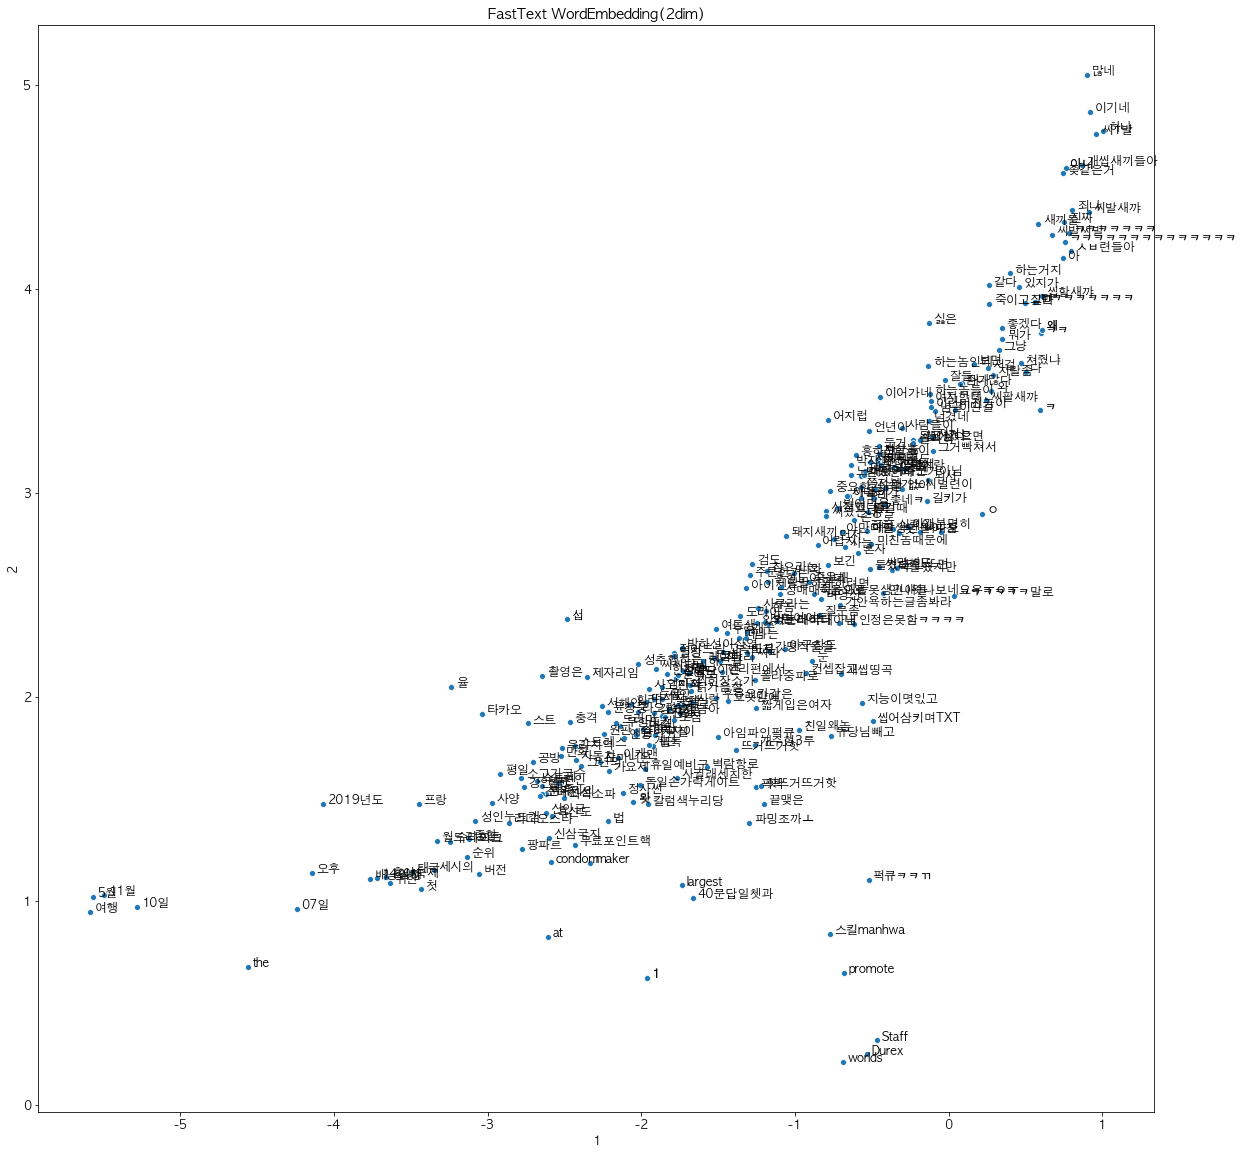

In [347]:
import seaborn as sns
from matplotlib import rc
from matplotlib import rcParams
import matplotlib.pyplot as plt
%matplotlib inline

rc('font', family='AppleGothic', size=12)

plt.rcParams['axes.unicode_minus'] = False

# figure size in inches
# plt.xlim(-5, 5)
# plt.ylim(-5, 5)
rcParams['figure.figsize'] = 20, 20
plot = sns.scatterplot(x=1, y=2, data=df)

# add annotations one by one with a loop
for line in range(0,df.shape[0]):
     plot.text(df[1][line]+0.03, df[2][line], df.word[line], horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.title("FastText WordEmbedding(2dim)")
plt.savefig("./word_embedding_2dim.png")
# 오른쪽 위일수록 욕
# 왼쪽 아래는 날짜 관련한 단어들
# 오른쪽 아래는 자주 나오지 않는 영단어들 등등 어느정도 군집화를 이룬것 같다.